#테스트 모델

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, BertModel, TFBertModel

#Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

# pytorch 의 경우 : 모델원본
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

#모델수정
config = BertConfig.from_pretrained('bert-base-multilingual-cased', output_hidden_states=True, hidden_dropout_prob=0.8, attention_probs_dropout_prob=0.2
                                    )
transformer_model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', config=config)
transformer_model = BertModel.from_pretrained('bert-base-multilingual-cased', config=config)
transformer_model.cuda()

#TensorFlow의 경우
model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
# 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')
# 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])
bert_outputs = bert_outputs[1]
sentiment_first = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(bert_outputs)
sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_first)
import tensorflow_addons as tfa
opt = tfa.optimizers.RectifiedAdam(lr=1.0e-5, weight_decay=0.0025)
sentiment_model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [ ]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss, MSELoss
from transformers import BertModel, BertConfig
class CustomBERTModel(nn.Module):
    def __init__(self):
          super(CustomBERTModel, self).__init__()
          self.num_labels = 2
          self.config = BertConfig.from_pretrained('bert-base-multilingual-cased', output_hidden_states=True, 
                                                   hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)
          self.bert = BertModel.from_pretrained("bert-base-multilingual-cased", config=self.config)
          ### New layers:
          self.dropout = nn.Dropout(0.3)
          self.linear2 = nn.Linear(768, self.num_labels)

    def forward(self, input_ids=None, attention_mask=None,
                token_type_ids=None, position_ids=None, head_mask=None,
                inputs_embeds=None, labels=None, output_attentions=None,
                output_hidden_states=None, return_dict=None,):
          outputs = self.bert(input_ids, attention_mask=attention_mask,
                              token_type_ids=token_type_ids, position_ids=position_ids,
                              head_mask=head_mask,inputs_embeds=inputs_embeds,
                              output_attentions=output_attentions, output_hidden_states=output_hidden_states,
                              return_dict=return_dict,)
          pooled_output = outputs[1]
          pooled_output = self.dropout(pooled_output)
          logits = self.linear2(pooled_output)

          loss = None
          if labels is not None:
              if self.num_labels == 1:
                  #  We are doing regression
                  loss_fct = MSELoss()
                  loss = loss_fct(logits.view(-1), labels.view(-1))
              else:
                  loss_fct = CrossEntropyLoss()
                  loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

          if not return_dict:
              output = (logits,) + outputs[2:]
              return ((loss,) + output) if loss is not None else output

          return logits

model = CustomBERTModel()
model.to(device)

가지치기 torch.nn.utils.prune

In [ ]:
import torch
import torch.nn.utils.prune as prune
parameters_to_prune = ()
for i in range(12):
    parameters_to_prune += (
        (transformer_model.encoder.layer[i].attention.self.key, 'weight'),
        (transformer_model.encoder.layer[i].attention.self.query, 'weight'),
        (transformer_model.encoder.layer[i].attention.self.value, 'weight'),
    )

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

확인

In [ ]:
for i in range(12):
    print(
        "Sparsity in Layer {}-th key weight: {:.2f}%".format(
            i+1,
            100. * float(torch.sum(transformer_model.encoder.layer[i].attention.self.key.weight == 0))
            / float(transformer_model.encoder.layer[i].attention.self.key.weight.nelement())
        )
    )
    print(
        "Sparsity in Layer {}-th query weightt: {:.2f}%".format(
            i+1,
            100. * float(torch.sum(transformer_model.encoder.layer[i].attention.self.query.weight == 0))
            / float(transformer_model.encoder.layer[i].attention.self.query.weight.nelement())
        )
    )
    print(
        "Sparsity in Layer {}-th value weight: {:.2f}%".format(
            i+1,
            100. * float(torch.sum(transformer_model.encoder.layer[i].attention.self.value.weight == 0))
            / float(transformer_model.encoder.layer[i].attention.self.value.weight.nelement())
        )
    )
    print()

    
numerator, denominator = 0, 0
for i in range(12):
    numerator += torch.sum(transformer_model.encoder.layer[i].attention.self.key.weight == 0)
    numerator += torch.sum(transformer_model.encoder.layer[i].attention.self.query.weight == 0)
    numerator += torch.sum(transformer_model.encoder.layer[i].attention.self.value.weight == 0)

    denominator += transformer_model.encoder.layer[i].attention.self.key.weight.nelement()
    denominator += transformer_model.encoder.layer[i].attention.self.query.weight.nelement()
    denominator += transformer_model.encoder.layer[i].attention.self.value.weight.nelement()
    
print("Global sparsity: {:.2f}%".format(100. * float(numerator) / float(denominator)))

# **네이버 영화리뷰 감정분석 with Hugging Face BERT**

BERT(Bidirectional Encoder Representations from Transformers)는 구글이 개발한 사전훈련(pre-training) 모델임.

아래의 Chris McCormick의 블로그를 참조하여 나에 맞게 수정함

< BERT Fine-Tuning Tutorial with PyTorch ><br>
-> https://mccormickml.com/2019/07/22/BERT-fine-tuning
<br>
BERT에 대해서 좀 더 자세한 설명은 박상길님과 Jay Alammar의 블로그를 참조하시기 바랍니다.

< BERT 톺아보기 ><br>
-> http://docs.likejazz.com/bert/

< The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning) ><br>
-> http://jalammar.github.io/illustrated-bert/

# **huggingface model custom**

저자 : 4nchez<br>
모델 : BERT<br>
데이터 : nsmc<br>
필요한 라이브러리(중요한건 bold함)<br>
-> pandas, numpy, random, time, datetime, **transformers**, **pytorch**, **tensorflw**

## **Import library**

In [ ]:
!pip install transformers sentencepiece

  Using cached https://files.pythonhosted.org/packages/50/0c/7d5950fcd80b029be0a8891727ba21e0cd27692c407c51261c3c921f6da3/transformers-4.1.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e5/2d/6d4ca4bef9a67070fa1cac508606328329152b1df10bdf31fb6e4e727894/sentencepiece-0.1.94-cp36-cp36m-manylinux2014_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/7d/34/09d19aff26edcc8eb2a01bed8e98f13a1537005d31e95233fd48216eed10/sacremoses-0.0.43.tar.gz
  Using cached https://files.pythonhosted.org/packages/0f/1c/e789a8b12e28be5bc1ce2156cf87cb522b379be9cadc7ad8091a4cc107c4/tokenizers-0.9.4-cp36-cp36m-manylinux2010_x86_64.whl
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=7b143da54dfef2176478a3d716d6c6763d243c5375533f3bf452179bd32b8f6a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random, time, datetime

from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, BertModel
from transformers import XLMRobertaConfig, XLMRobertaModel, XLMRobertaTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

## **데이터 로드**

In [ ]:
# 네이버 영화리뷰 감정분석 데이터 다운로드
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 22.41 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [ ]:
# 판다스로 훈련셋과 테스트셋 데이터 로드
train = pd.read_csv("nsmc/ratings_train.txt", sep='\t')
test = pd.read_csv("nsmc/ratings_test.txt", sep='\t')

print(train.shape)
print(test.shape)

(150000, 3)
(50000, 3)


훈련셋 150,000개와 테스트셋 50,000개의 데이터가 존재합니다.
<br>
<br>
<br>

## **데이터 전처리**

**Train_set**

In [ ]:
def Make_sentence(tokenizer, sentences):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 128,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])
      
  # input_ids = torch.cat(input_ids, dim=0)
  # attention_masks = torch.cat(attention_masks, dim=0)
  return input_ids, attention_masks

In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base', do_lower_case=False)

In [ ]:
# print(train.isnull().any())
# train[train['document'].isnull()]
print(train.shape)
print("train null value : " ,train.isnull().sum())
train_set=train.dropna()
sentences = train_set['document'].values
labels = train_set['label'].values
print(len(sentences))
print(len(labels))

input_ids, attention_masks = Make_sentence(tokenizer, sentences)
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Token IDs:', attention_masks[0])
print('Labels :', labels[0])

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


(150000, 3)
train null value :  id          0
document    5
label       0
dtype: int64
149995
149995


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  아 더빙.. 진짜 짜증나네요 목소리
Token IDs: tensor([     0,   7159,   6116, 101895,      5,      5, 113621,      6,  74280,
         18128,   3497,  25861, 209932,      2,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1

**9:1로 나누기**

In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

**Test_set**

In [ ]:
print(test.shape)
print(test.isnull().sum())
test_set=test.dropna()
print(test_set.shape)
sentences = test_set['document'].values
labels = test_set['label'].values
print(len(sentences))
print(len(labels))

input_ids, attention_masks = Make_sentence(tokenizer, sentences)
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Token IDs:', attention_masks[0])
print('Labels :', labels[0])

# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(input_ids, attention_masks, labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

(50000, 3)
id          0
document    3
label       0
dtype: int64
(49997, 3)
49997
49997


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  굳 ㅋ
Token IDs: tensor([     0,      6, 198249,      6, 204615,      2,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1

## **모델 생성**

In [ ]:
# GPU 디바이스 이름 구함
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
class CustomBERTModel(nn.Module):
    def __init__(self):
          super(CustomBERTModel, self).__init__()
          self.num_labels = 2
          # self.config = BertConfig.from_pretrained('bert-base-multilingual-cased', output_hidden_states=True, 
          #                                          hidden_dropout_prob=0.2, attention_probs_dropout_prob=0.2)
          # self.bert = BertModel.from_pretrained("bert-base-multilingual-cased", config=self.config)
          self.config = XLMRobertaConfig.from_pretrained('xlm-roberta-base', output_hidden_states=True, 
                                                   hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1)
          self.bert = XLMRobertaModel.from_pretrained("xlm-roberta-base", config=self.config)
          ### New layers:
          self.linear1 = nn.Linear(768, 768)
          self.dropout = nn.Dropout(0.1)
          self.linear2 = nn.Linear(768, self.num_labels)

    def forward(self, input_ids=None, attention_mask=None,
                token_type_ids=None, position_ids=None, head_mask=None,
                inputs_embeds=None, labels=None, output_attentions=None,
                output_hidden_states=None, return_dict=None,):
          outputs = self.bert(input_ids, attention_mask=attention_mask,
                              token_type_ids=token_type_ids, position_ids=position_ids,
                              head_mask=head_mask,inputs_embeds=inputs_embeds,
                              output_attentions=output_attentions, output_hidden_states=output_hidden_states,
                              return_dict=return_dict,)
          pooled_output1 = outputs[1]
          pooled_output = self.linear1(pooled_output1)
          pooled_output = self.dropout(pooled_output)
          logits = self.linear2(pooled_output)

          loss = None
          if labels is not None:
              if self.num_labels == 1:
                  #  We are doing regression
                  loss_fct = MSELoss()
                  loss = loss_fct(logits.view(-1), labels.view(-1))
              else:
                  loss_fct = CrossEntropyLoss()
                  loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

          if not return_dict:
              output = (logits,) + outputs[2:]
              return ((loss,) + output) if loss is not None else output

          return logits

model = CustomBERTModel().to(device)
print(model)


CustomBERTModel(
  (bert): XLMRobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 203 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (250002, 768)
bert.embeddings.position_embeddings.weight                (514, 768)
bert.embeddings.token_type_embeddings.weight                (1, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

In [ ]:
import torch.nn.utils.prune as prune
parameters_to_prune = ()
for i in range(12):
    parameters_to_prune += (
        (model.bert.encoder.layer[i].attention.self.key, 'weight'),
        (model.bert.encoder.layer[i].attention.self.query, 'weight'),
        (model.bert.encoder.layer[i].attention.self.value, 'weight'),
    )

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

In [ ]:
for i in range(12):
    print(
        "Sparsity in Layer {}-th key weight: {:.2f}%".format(
            i+1,
            100. * float(torch.sum(model.bert.encoder.layer[i].attention.self.key.weight == 0))
            / float(model.bert.encoder.layer[i].attention.self.key.weight.nelement())
        )
    )
    print(
        "Sparsity in Layer {}-th query weightt: {:.2f}%".format(
            i+1,
            100. * float(torch.sum(model.bert.encoder.layer[i].attention.self.query.weight == 0))
            / float(model.bert.encoder.layer[i].attention.self.query.weight.nelement())
        )
    )
    print(
        "Sparsity in Layer {}-th value weight: {:.2f}%".format(
            i+1,
            100. * float(torch.sum(model.bert.encoder.layer[i].attention.self.value.weight == 0))
            / float(model.bert.encoder.layer[i].attention.self.value.weight.nelement())
        )
    )
    print()

    
numerator, denominator = 0, 0
for i in range(12):
    numerator += torch.sum(model.bert.encoder.layer[i].attention.self.key.weight == 0)
    numerator += torch.sum(model.bert.encoder.layer[i].attention.self.query.weight == 0)
    numerator += torch.sum(model.bert.encoder.layer[i].attention.self.value.weight == 0)

    denominator += model.bert.encoder.layer[i].attention.self.key.weight.nelement()
    denominator += model.bert.encoder.layer[i].attention.self.query.weight.nelement()
    denominator += model.bert.encoder.layer[i].attention.self.value.weight.nelement()
    
print("Global sparsity: {:.2f}%".format(100. * float(numerator) / float(denominator)))

Sparsity in Layer 1-th key weight: 8.77%
Sparsity in Layer 1-th query weightt: 9.43%
Sparsity in Layer 1-th value weight: 30.24%

Sparsity in Layer 2-th key weight: 13.04%
Sparsity in Layer 2-th query weightt: 12.82%
Sparsity in Layer 2-th value weight: 32.48%

Sparsity in Layer 3-th key weight: 16.19%
Sparsity in Layer 3-th query weightt: 16.04%
Sparsity in Layer 3-th value weight: 30.36%

Sparsity in Layer 4-th key weight: 18.33%
Sparsity in Layer 4-th query weightt: 18.02%
Sparsity in Layer 4-th value weight: 25.54%

Sparsity in Layer 5-th key weight: 17.14%
Sparsity in Layer 5-th query weightt: 16.98%
Sparsity in Layer 5-th value weight: 25.25%

Sparsity in Layer 6-th key weight: 19.16%
Sparsity in Layer 6-th query weightt: 18.73%
Sparsity in Layer 6-th value weight: 24.63%

Sparsity in Layer 7-th key weight: 16.96%
Sparsity in Layer 7-th query weightt: 16.50%
Sparsity in Layer 7-th value weight: 27.09%

Sparsity in Layer 8-th key weight: 18.73%
Sparsity in Layer 8-th query weightt

## **Training**

In [ ]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 4

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [26]:
import random
import numpy as np
 
seed_val = 42
 
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
 
training_stats = []
total_t0 = time.time()
 
for epoch_i in range(0, epochs):
    #               Training
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
 
    t0 = time.time()
 
    total_train_loss = 0
 
    model.train()
 
    for step, batch in enumerate(train_dataloader):
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
 
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
 
        model.zero_grad()        
 
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        loss = outputs[0]
        
        total_train_loss += loss.item()
 
        loss.backward()
 
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
 
        optimizer.step()
 
        scheduler.step()
 
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)
 
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    #               Validation
    print("")
    print("Running Validation...")
 
    t0 = time.time()
    
    model.eval()
 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
 
    for batch in validation_dataloader:
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]
            
        # total_eval_loss += logits.item()
 
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
 
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    # avg_val_loss = total_eval_loss / len(validation_dataloader)    
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Accuracy: {0:.2f}".format(avg_val_accuracy))
    # print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
 
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            # 'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
 
print("")
print("Training complete!")
 
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch   500  of  4,219.    Elapsed: 0:06:10.
  Batch 1,000  of  4,219.    Elapsed: 0:12:24.
  Batch 1,500  of  4,219.    Elapsed: 0:18:39.
  Batch 2,000  of  4,219.    Elapsed: 0:24:54.
  Batch 2,500  of  4,219.    Elapsed: 0:31:08.
  Batch 3,000  of  4,219.    Elapsed: 0:37:23.
  Batch 3,500  of  4,219.    Elapsed: 0:43:38.
  Batch 4,000  of  4,219.    Elapsed: 0:49:52.

  Average training loss: 0.33
  Training epcoh took: 0:52:36

Running Validation...
  Validation Accuracy: 0.89
  Validation took: 0:01:41

======== Epoch 2 / 4 ========
Training...
  Batch   500  of  4,219.    Elapsed: 0:06:15.
  Batch 1,000  of  4,219.    Elapsed: 0:12:29.
  Batch 1,500  of  4,219.    Elapsed: 0:18:44.
  Batch 2,000  of  4,219.    Elapsed: 0:24:59.
  Batch 2,500  of  4,219.    Elapsed: 0:31:13.
  Batch 3,000  of  4,219.    Elapsed: 0:37:28.
  Batch 3,500  of  4,219.    Elapsed: 0:43:43.
  Batch 4,000  of  4,219.    Elapsed: 0:49:57.

  Average training lo

In [29]:
import pandas as pd
 
# Display floats with two decimal places.
pd.set_option('precision', 4)
 
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)
 
# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')
 
# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])
 
# Display the table.
df_stats

,Training Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,
1,0.3328,0.8897,0:52:36,0:01:41
2,0.2447,0.8950,0:52:41,0:01:41
3,0.1974,0.9019,0:52:40,0:01:41
4,0.1623,0.9027,0:52:40,0:01:41


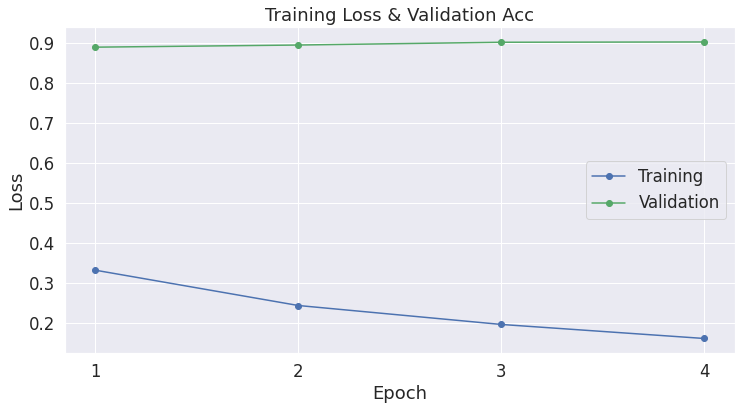

In [30]:
import matplotlib.pyplot as plt
% matplotlib inline
 
import seaborn as sns
 
# Use plot styling from seaborn.
sns.set(style='darkgrid')
 
# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
 
# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Accur.'], 'g-o', label="Validation")
 
# Label the plot.
plt.title("Training Loss & Validation Acc")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])
 
plt.show()

## **테스트셋 평가**

In [31]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

pred, real = [], [] #f1-score용 배열
# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 300 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    pred.append(np.argmax(logits, axis=1).flatten())
    real.append(label_ids.flatten())
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.5f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

  Batch   300  of  1,563.    Elapsed: 0:01:05.
  Batch   600  of  1,563.    Elapsed: 0:02:10.
  Batch   900  of  1,563.    Elapsed: 0:03:15.
  Batch 1,200  of  1,563.    Elapsed: 0:04:19.
  Batch 1,500  of  1,563.    Elapsed: 0:05:24.

Accuracy: 0.90039
Test took: 0:05:37


In [32]:
from sklearn.metrics import classification_report
print(classification_report(np.concatenate( real, axis=0 ),np.concatenate( pred, axis=0 ), digits=4))

              precision    recall  f1-score   support

           0     0.9110    0.8860    0.8983     24826
           1     0.8905    0.9147    0.9024     25171

    accuracy                         0.9004     49997
   macro avg     0.9008    0.9003    0.9004     49997
weighted avg     0.9007    0.9004    0.9004     49997



## **새로운 문장 테스트**

In [ ]:
# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [ ]:
# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [ ]:
logits = test_sentences(['연기는 별로지만 재미 하나는 끝내줌!'])

print(logits)
print(np.argmax(logits))

[[-1.1823558  1.5893534]]
1


In [ ]:
logits = test_sentences(['주연배우가 아깝다. 총체적 난국...'])

print(logits)
print(np.argmax(logits))

[[ 2.878643  -3.4957294]]
0


학습한 모델을 가지고 실제 문장을 넣어봤습니다. 출력 로짓은 소프트맥스가 적용되지 않은 상태입니다. argmax로 더 높은 값의 위치를 라벨로 설정하면 됩니다. 0은 부정, 1은 긍정입니다. 위와 같이 새로운 문장에도 잘 분류를 하고 있습니다.
<br>
<br>
<br>

## Test

자바스크립트 30분<br>

function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button").click() 
}setInterval(ClickConnect, 1800000)